In [ ]:
import rdatkit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'text.usetex': False,"svg.fonttype": 'none'})

In [2]:
def normalize(data,DMS=False,seq=None):
    
    # just 0 out all negative values
    data = np.where(data<0,0,data)
    #data = np.where(data>1,1,data)
    # and if dms nan out all non A,C
    if DMS:
        data = np.where(~np.isin(np.array(list(seq)),['A','C']),np.nan,data)
    normalized_data = data.copy()
    
    # remove outlier defined as value above the max of these two values
        # the traditional Q3+1.5IQR
        # 95 percentile
    q3 = np.percentile(data, 75)
    iqr = q3 - np.percentile(data, 25)
    outlier_cutoff = q3 + (1.5*iqr)
    data_filtered = np.where(data>outlier_cutoff,np.nan,data)
    cutoff = max(max(data_filtered),np.percentile(data, 95))
    data = np.where(data>cutoff,np.nan,data)
    data = data[~np.isnan(data)]
    
    # with the filtered data take the top 10%
    # and use the mean of those value as scale factor
    scale_factor_cut = np.percentile(data, 90)
    data = np.where(data<scale_factor_cut,np.nan,data)
    data = data[~np.isnan(data)]
    scale_factor = data.mean()
    
    # return original data, scaled by this factor
    # (and negatives 0-d out)
    normalized_data = normalized_data/scale_factor
    return normalized_data,scale_factor
    

## SHAPE

In [78]:
rdat = rdatkit.RDATFile()
rdat.load(open('../data/m2seq/RH_NovaSeq_2023_06_06_SL5_M2seq_RTB002_SSII_Hepes_2A3.rdat'))
rdat.validate()
constructs = ['SL5_SARS_CoV_2','SL5_MERS_GCadded','SL5_BtCoV_HKU5_GCadded']
WT = {c:{} for c in constructs}
single_mut = {c:{} for c in constructs}
double_mut = {c:{} for c in constructs}
rescue_mut = {c:{} for c in constructs}
disrupt_mut = {c:{} for c in constructs}
for i, data in enumerate(rdat.constructs['SL5_M2seq'].data):
    name = data.annotations['name'][0]
    vals,scale = normalize(np.array(data.values))
    errs = np.array(data.errors)/scale
    for c in constructs:
        if c in name:
            mutants = name.split(c)[1].split('pad')[0].split('_')[1:-1]
            if len(mutants) == 1:
                mut_pos = int(mutants[0].split('-')[0][:-1])
                
                if mut_pos in single_mut[c]:
                    single_mut[c][mut_pos]['values'].append(vals)
                    single_mut[c][mut_pos]['errors'].append(errs)
                else:
                    single_mut[c][mut_pos] = {'values':[vals],'errors':[errs]}
            elif len(mutants) == 2:
                mut_pos = (int(mutants[0].split('-')[0][:-1]), int(mutants[1].split('-')[0][:-1]))
                wt_pair = [mutants[0].split('-')[0][-1],mutants[1].split('-')[0][-1]]
                if wt_pair in [['G','C'],['C','G'],['A','U'],['U','A']]:
                    new_pair = [mutants[0].split('-')[1],mutants[1].split('-')[1]]
                    if new_pair in [['G','C'],['C','G'],['A','U'],['U','A']]:
                        if mut_pos in rescue_mut[c]:
                            rescue_mut[c][mut_pos]['values'].append(vals)
                            rescue_mut[c][mut_pos]['errors'].append(errs)
                        else:
                            rescue_mut[c][mut_pos] = {'values':[vals],'errors':[errs]}
                    else:
                        if mut_pos in disrupt_mut[c]:
                            disrupt_mut[c][mut_pos]['values'].append(vals)
                            disrupt_mut[c][mut_pos]['errors'].append(errs)
                        else:
                            disrupt_mut[c][mut_pos] = {'values':[vals],'errors':[errs]}
                if mut_pos in double_mut[c]:
                    double_mut[c][mut_pos]['values'].append(vals)
                    double_mut[c][mut_pos]['errors'].append(errs)
                else:
                    double_mut[c][mut_pos] = {'values':[vals],'errors':[errs]}
            elif len(mutants)==0:
                WT[c]['values'] = vals
                WT[c]['errors'] = errs

/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


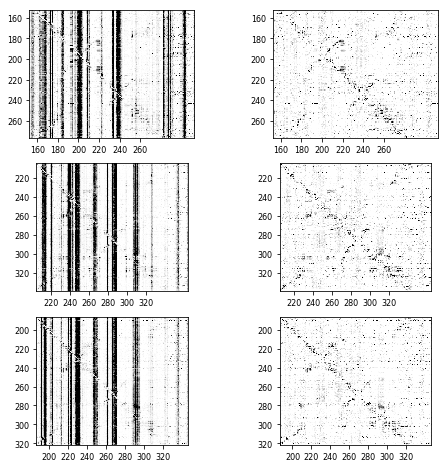

In [79]:
fig, ax = plt.subplots(len(constructs),2,figsize=(8,8))
single_mut_ = {}
for cn,c in enumerate(constructs):
    single_mut_[c] = {i:np.array(data['values']) for i, data in single_mut[c].items()}
    SARS2sing = np.array([single_mut_[c][i].mean(axis=0) for i in range(len(single_mut_[c].keys()))])
    mu = np.nanmean(SARS2sing,axis=0)
    sigma = np.nanstd(SARS2sing,axis=0)
    Z = (SARS2sing-mu)/sigma

    im = ax[cn,0].imshow(SARS2sing,cmap='Greys',vmin=0,vmax=1)
    im = ax[cn,1].imshow(Z,cmap='Greys',vmin=0,vmax=5)
    
    if cn == 0:
        first_nt = 159
        offset = 6
    elif cn == 1:
        first_nt = 205
        offset = 0
    elif cn==2:
        first_nt = 187
        offsest = 0
    rep = 20
    start_i = rep-((first_nt-offset)%rep)
    start_n = start_i+first_nt-offset
    ticks = list(range(start_i,len(single_mut[c].keys()),rep))
    labels = list(range(start_n,start_n+len(single_mut[c].keys()),rep))
    ax[cn,0].set_xticks(ticks)
    ax[cn,0].set_xticklabels(labels,size=8)
    ax[cn,1].set_xticks(ticks)
    ax[cn,1].set_xticklabels(labels,size=8)
    ax[cn,0].set_yticks(ticks)
    ax[cn,0].set_yticklabels(labels,size=8)
    ax[cn,1].set_yticks(ticks)
    ax[cn,1].set_yticklabels(labels,size=8)
plt.savefig('SHAPE_m2seq_largelib.svg')

## DMS

In [73]:
rdat = rdatkit.RDATFile()
rdat.load(open('../data/m2seq/RH_NovaSeq_2023_06_06_SL5_M2seq_RTB000_Marathon_Bicine_3pct_DMS.rdat'))
rdat.validate()
constructs = ['SL5_SARS_CoV_2','SL5_MERS_GCadded','SL5_BtCoV_HKU5_GCadded']
trims = [(31,-15),(26,-20),(26,-20)]
WT = {c:{} for c in constructs}
single_mut = {c:{} for c in constructs}
double_mut = {c:{} for c in constructs}
rescue_mut = {c:{} for c in constructs}
disrupt_mut = {c:{} for c in constructs}
for i, data in enumerate(rdat.constructs['SL5_M2seq'].data):
    name = data.annotations['name'][0]
    
    for trim,c in zip(trims,constructs):
        vals,scale = normalize(np.array(data.values), DMS=False,seq=data.annotations['sequence'][0][trim[0]:trim[1]])
        # errs = np.array(data.errors)/scale
        if c in name:
            mutants = name.split(c)[1].split('pad')[0].split('_')[1:-1]
            if len(mutants) == 1:
                mut_pos = int(mutants[0].split('-')[0][:-1])
                
                if mut_pos in single_mut[c]:
                    single_mut[c][mut_pos].append(vals)
                else:
                    single_mut[c][mut_pos] = [vals]
            elif len(mutants) == 2:
                mut_pos = (int(mutants[0].split('-')[0][:-1]), int(mutants[1].split('-')[0][:-1]))
                wt_pair = [mutants[0].split('-')[0][-1],mutants[1].split('-')[0][-1]]
                if wt_pair in [['G','C'],['C','G'],['A','U'],['U','A']]:
                    new_pair = [mutants[0].split('-')[1],mutants[1].split('-')[1]]
                    if new_pair in [['G','C'],['C','G'],['A','U'],['U','A']]:
                        if mut_pos in rescue_mut[c]:
                            rescue_mut[c][mut_pos].append(vals)
                        else:
                            rescue_mut[c][mut_pos] = [vals]
                    else:
                        if mut_pos in disrupt_mut[c]:
                            disrupt_mut[c][mut_pos].append(vals)
                        else:
                            disrupt_mut[c][mut_pos] = [vals]
                if mut_pos in double_mut[c]:
                    double_mut[c][mut_pos].append(vals)
                else:
                    double_mut[c][mut_pos] = [vals]
            elif len(mutants)==0:
                WT[c] = vals

/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater


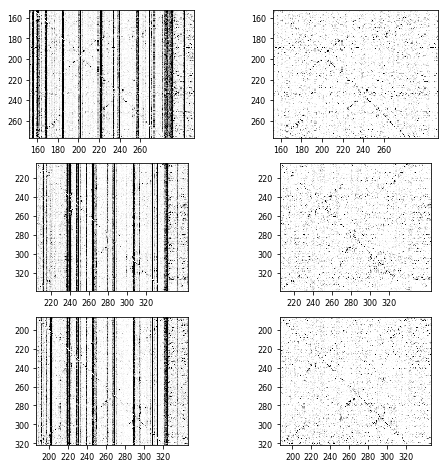

In [77]:
fig, ax = plt.subplots(len(constructs),2,figsize=(8,8))
for cn,c in enumerate(constructs):
    single_mut[c] = {i:np.array(data) for i, data in single_mut[c].items()}
    SARS2sing = np.array([single_mut[c][i].mean(axis=0) for i in range(len(single_mut[c].keys()))])
    #print(SARS2sing[0])
    mu = np.nanmean(SARS2sing,axis=0)
    sigma = np.nanstd(SARS2sing,axis=0)
    Z = (SARS2sing-mu)/sigma

    im = ax[cn,0].imshow(SARS2sing,cmap='Greys',vmin=0,vmax=1)
    im = ax[cn,1].imshow(Z,cmap='Greys',vmin=0,vmax=5)
    if cn == 0:
        first_nt = 159
        offset = 6
    elif cn == 1:
        first_nt = 205
        offset = 0
    elif cn==2:
        first_nt = 187
        offsest = 0
    rep = 20
    start_i = rep-((first_nt-offset)%rep)
    start_n = start_i+first_nt-offset
    ticks = list(range(start_i,len(single_mut[c].keys()),rep))
    labels = list(range(start_n,start_n+len(single_mut[c].keys()),rep))
    ax[cn,0].set_xticks(ticks)
    ax[cn,0].set_xticklabels(labels,size=8)
    ax[cn,1].set_xticks(ticks)
    ax[cn,1].set_xticklabels(labels,size=8)
    ax[cn,0].set_yticks(ticks)
    ax[cn,0].set_yticklabels(labels,size=8)
    ax[cn,1].set_yticks(ticks)
    ax[cn,1].set_yticklabels(labels,size=8)
plt.savefig('DMS_m2seq_largelib.svg')

In [46]:
def plot_simple_react(rdat_mod_f,rdat_nomod_f,title,out,first_nt):
    rdat_mod = rdatkit.RDATFile()
    rdat_mod.load(open(rdat_mod_f))
    rdat_mod.validate()

    rdat_nomod = rdatkit.RDATFile()
    rdat_nomod.load(open(rdat_nomod_f))
    rdat_nomod.validate()


    WT = {c:{} for c in constructs}
    single_mut = {c:{} for c in constructs}

    print(rdat_mod.constructs)
    for i, (data, nmdata) in enumerate(zip(rdat_mod.constructs[title].data,rdat_nomod.constructs[title].data)):
        name = data.annotations['mutation'][0]
        if name != nmdata.annotations['mutation'][0]:
            print("DATA WAS NOT ORDERED")
        if name != "WT":
            mut_pos = int(name[1:-1])
            #print(data.__dict__)
            vals,scale = normalize(np.array(data.values)-np.array(nmdata.values))#, DMS=True,seq=data.sequence)
            # errs = np.array(data.errors)/scale
            # nm,nmscale = normalize(np.array(nmdata.values))
            if mut_pos in single_mut[c]:
                single_mut[c][mut_pos].append(vals)
            else:
                single_mut[c][mut_pos] = [vals]
    fig, ax = plt.subplots(1,2,figsize=(8,8))
    single_mut[c] = {i:np.array(data) for i, data in single_mut[c].items()}
    SARS2sing = np.array([single_mut[c][i+1].mean(axis=0) for i in range(len(single_mut[c].keys()))])
    
    rep = 20
    start_i = rep-((first_nt-1)%rep)
    start_n = start_i+first_nt-1
    ticks = list(range(start_i,len(single_mut[c].keys()),rep))
    labels = list(range(start_n,start_n+len(single_mut[c].keys()),rep))

    mu = np.nanmean(SARS2sing,axis=0)
    sigma = np.nanstd(SARS2sing,axis=0)
    Z = (SARS2sing-mu)/sigma

    im = ax[0].imshow(SARS2sing,cmap='Greys',vmin=0,vmax=1)
    im = ax[1].imshow(Z,cmap='Greys',vmin=0,vmax=5)
    ax[0].set_xticks(ticks)
    ax[0].set_xticklabels(labels)
    ax[1].set_xticks(ticks)
    ax[1].set_xticklabels(labels)
    ax[0].set_yticks(ticks)
    ax[0].set_yticklabels(labels)
    ax[1].set_yticks(ticks)
    ax[1].set_yticklabels(labels)
    plt.savefig(out)

defaultdict(<type 'list'>, {'SL5-6': <rdatkit.handler.RDATSection object at 0x7f45354ae490>})


/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide
/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in divide
/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in divide


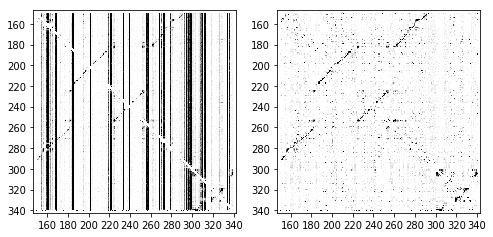

In [48]:
plot_simple_react('../data/m2seq/SL5-6-DMS_SL5-6.reactivity.rdat','../data/m2seq/SL5-6-NM_SL5-6.reactivity.rdat',
                  'SL5-6','DMS_SL56_m2seq.svg',148)

defaultdict(<type 'list'>, {'SL5trunc': <rdatkit.handler.RDATSection object at 0x7f45354aea50>})


/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide
/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in divide
/home/rachael/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in divide


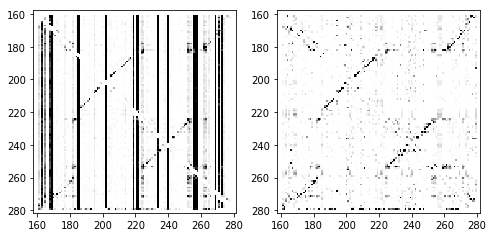

In [49]:
plot_simple_react('../data/m2seq/SL5trunc-DMS_SL5trunc.reactivity.rdat','../data/m2seq/SL5trunc-NM_SL5trunc.reactivity.rdat',
                  "SL5trunc",'DMS_SL5runc_m2seq.svg',159)